In [1]:
! pip install keras
import pandas as pd
import sklearn 
import numpy as np
import dotscience as ds
import matplotlib.pyplot as plt
import keras
from keras import models, layers, utils, regularizers



from numpy.random import seed
seed(1)

%matplotlib inline


You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


In [2]:
ds.interactive()

In [3]:
ds.start()

In [4]:
df = pd.read_csv(ds.input("train.csv"))

In [5]:
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df.Sex.unique()

array(['male', 'female'], dtype=object)

In [7]:
df['Sex_binary'] = np.where(df['Sex'] == "female", 1, 0)
df.drop(columns='Sex', inplace=True)

In [8]:
# set Embarked_ternary to 1 for C, 2 for Q, 3 for S
df['Embarked_ternary'] = np.where(df["Embarked"] == "C", 1, 
         (np.where(df["Embarked"] == "Q", 2, 3)))

In [9]:
count_nan = len(df['Cabin']) - df['Cabin'].count()
print(count_nan)

687


OK, so most of the Cabin values are NaN, so we can probably drop this column.

In [10]:
df.drop(columns='Cabin', inplace=True)

Slightly more likely to survive if younger:

In [11]:
df.groupby(['Survived']).Age.mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

Higher average fare amongst survivors:

In [12]:

df.groupby(['Survived']).Fare.mean()

Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64

How does survival vary with embarkation point?

In [13]:
print("number embarked at Cherbourg", len(df.loc[df['Embarked_ternary'] == 1]))
print("average survival status", df.loc[df['Embarked_ternary'] == 1].Survived.mean())
print("\n")
print("number embarked at Queenstown", len(df.loc[df['Embarked_ternary'] == 2]))
print("average survival status", df.loc[df['Embarked_ternary'] == 2].Survived.mean())
print("\n")
print("number embarked at Southampton", len(df.loc[df['Embarked_ternary'] == 3]))
print("average survival status", df.loc[df['Embarked_ternary'] == 3].Survived.mean())

number embarked at Cherbourg 168
average survival status 0.5535714285714286


number embarked at Queenstown 77
average survival status 0.38961038961038963


number embarked at Southampton 646
average survival status 0.33900928792569657


OK, so there is some evidence that embarking at Cherbourg is correlated with survival. So let's turn embarkation_ternary into a binary condition: emarbarked_at_cherbourg

In [14]:
df['Embarked_at_cherbourg'] = np.where(df['Embarked_ternary'] == 1, 1, 0)
df.drop(columns="Embarked_ternary", inplace=True)

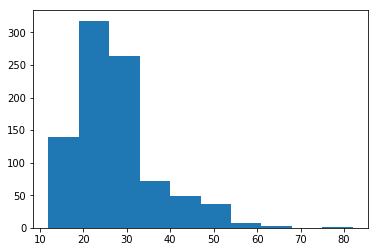

In [15]:
# how do the name lengths vary? And are they correlated with survival?

names_lens = [(name[1], len(name[1])) for name in df["Name"].iteritems()]
name_lens = [name_len[1] for name_len in names_lens]
plt.hist(name_lens)
plt.show()

In [16]:
# add an int value for name length
df['Name_len'] = [len(name[1]) for name in df["Name"].iteritems()]

In [17]:
df.corr()["Survived"]

PassengerId             -0.005007
Survived                 1.000000
Pclass                  -0.338481
Age                     -0.077221
SibSp                   -0.035322
Parch                    0.081629
Fare                     0.257307
Sex_binary               0.543351
Embarked_at_cherbourg    0.168240
Name_len                 0.332350
Name: Survived, dtype: float64

woah, having a long name is almost as highly correlated with survival as passanger class!

In [18]:
# todo: engineer ticket class
# for now, we'll just drop it

df.drop(columns=['PassengerId', 'Embarked', 'Name', 'Ticket'], inplace=True)

In [19]:
df.dtypes

Survived                   int64
Pclass                     int64
Age                      float64
SibSp                      int64
Parch                      int64
Fare                     float64
Sex_binary                 int64
Embarked_at_cherbourg      int64
Name_len                   int64
dtype: object

In [20]:
df.isnull().any()

Survived                 False
Pclass                   False
Age                       True
SibSp                    False
Parch                    False
Fare                     False
Sex_binary               False
Embarked_at_cherbourg    False
Name_len                 False
dtype: bool

We have some null ages. Let's see how many.

In [21]:
len(df.loc[df.Age.isnull()])

177

In [22]:
# naively fill nulls for now. Better to predict missing ages on basis of available data.

# test data also has nulls, so fill those in in same way.
df.fillna(df.mean(), inplace=True)

In [23]:
# get Survived/not Survived as  categorical value, to make compatible  with network and to use categorical_crossentropy as loss metric.
(train_passengers, train_labels) = (df.drop('Survived', axis=1), keras.utils.to_categorical(df['Survived'], num_classes=None, dtype='float32'))

In [24]:
train_labels.shape

(891, 2)

In [25]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train_passengers)
scaler.transform(train_passengers, copy=False)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 0.82737724, -0.5924806 ,  0.43279337, ..., -0.73769513,
        -0.48204268, -0.42745127],
       [-1.56610693,  0.63878901,  0.43279337, ...,  1.35557354,
         2.0745051 ,  2.59096206],
       [ 0.82737724, -0.2846632 , -0.4745452 , ...,  1.35557354,
        -0.48204268, -0.53525175],
       ...,
       [ 0.82737724,  0.        ,  0.43279337, ...,  1.35557354,
        -0.48204268,  1.40515682],
       [-1.56610693, -0.2846632 , -0.4745452 , ..., -0.73769513,
         2.0745051 , -0.64305222],
       [ 0.82737724,  0.17706291, -0.4745452 , ..., -0.73769513,
        -0.48204268, -0.85865317]])

In [26]:
# train_passengers is df
train_passengers[train_passengers.columns] = scaler.fit_transform(train_passengers[train_passengers.columns])

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [27]:
# make a function with preceding data-wrangling steps, so that we can perform the same operations on the test set
def wrangle(df):
    """
    takes a df with same format as training set.
    returns df in same format as modified training set
    """
    df['Sex_binary'] = np.where(df['Sex'] == "female", 1, 0)
    df.drop(columns='Sex', inplace=True)
    df['Embarked_ternary'] = np.where(df["Embarked"] == "C", 1, 
         (np.where(df["Embarked"] == "Q", 2, 3)))
    df.drop(columns='Cabin', inplace=True)
    df['Embarked_at_cherbourg'] = np.where(df['Embarked_ternary'] == 1, 1, 0)
    df.drop(columns="Embarked_ternary", inplace=True)
    names_lens = [(name[1], len(name[1])) for name in df["Name"].iteritems()]
    name_lens = [name_len[1] for name_len in names_lens]
    df['Name_len'] = [len(name[1]) for name in df["Name"].iteritems()]    
    df.drop(columns=['PassengerId', 'Embarked', 'Name', 'Ticket'], inplace=True)
    
    # naively fill in nulls for now
    df.fillna(df.mean(), inplace=True)
    return df

In [28]:
# load and transform test data
df_test = pd.read_csv(ds.input("test.csv"))
df_test = wrangle(df_test)

In [29]:
test_passengers = df_test
test_passengers[test_passengers.columns] = scaler.fit_transform(test_passengers[test_passengers.columns])

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [30]:
train_passengers.shape

(891, 8)

In [31]:
train_labels.shape

(891, 2)

In [32]:
from keras.layers import Dense, Activation, Dropout
from keras import callbacks


network = models.Sequential()

network.add(layers.Dense(input_dim=train_passengers.shape[1], units=128,
                 kernel_initializer='normal', bias_initializer='zeros', kernel_regularizer=regularizers.l2(ds.parameter("reg_lambda", 0.007))))

network.add(Activation('relu'))

for i in range(0, 5):
    network.add(layers.Dense(units=128, kernel_initializer='normal',
                     bias_initializer='zeros'))
    network.add(Activation('relu'))
    network.add(Dropout(.25))

network.add(layers.Dense(units=2))
network.add(Activation('softmax'))

network.compile(loss='categorical_crossentropy', optimizer=ds.parameter("optimizer", 'adam'), metrics=['accuracy'])

# TODO: record loss history: https://keras.io/callbacks/#example-recording-loss-history
# from keras.callbacks import ModelCheckpoint
# checkpointer = keras.callbacks.ModelCheckpoint(filepath="weights.h5", monitor='categorical_crossentropy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

network.fit(train_passengers, train_labels, epochs=ds.parameter("epochs", 700), verbose=2, validation_split=0.1, callbacks=[callbacks.EarlyStopping(monitor='val_acc', patience=2)])

# network.fit(train_passengers, train_labels, epochs=700, verbose=2, validation_split=0.1)

#get the highest validation accuracy of the training epochs
acc = np.amax(network.history.history['acc'])

ds.add_summary('acc%', acc)
# ds.add_parameters(regulariser="none", epocs=700, batch_size="default", optimizer="adam")


print('Best validation acc of epoch:', acc)


Train on 801 samples, validate on 90 samples
Epoch 1/700
 - 1s - loss: 0.6592 - acc: 0.6355 - val_loss: 0.5045 - val_acc: 0.8000
Epoch 2/700
 - 0s - loss: 0.4918 - acc: 0.7903 - val_loss: 0.4128 - val_acc: 0.8333
Epoch 3/700
 - 0s - loss: 0.4655 - acc: 0.8140 - val_loss: 0.4420 - val_acc: 0.8222
Epoch 4/700
 - 0s - loss: 0.4729 - acc: 0.8065 - val_loss: 0.4124 - val_acc: 0.8333
Epoch 5/700
 - 0s - loss: 0.4488 - acc: 0.8202 - val_loss: 0.3862 - val_acc: 0.8556
Epoch 6/700
 - 0s - loss: 0.4192 - acc: 0.8277 - val_loss: 0.3845 - val_acc: 0.8444
Epoch 7/700
 - 0s - loss: 0.4176 - acc: 0.8365 - val_loss: 0.3685 - val_acc: 0.8444
Best validation acc of epoch: 0.83645443196005


With L2 regularisation:

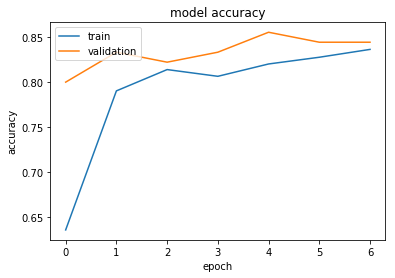

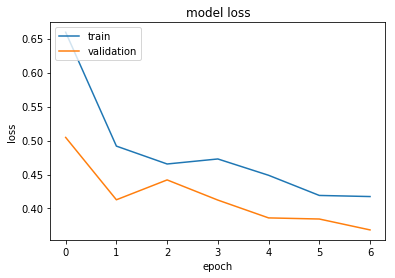

In [33]:
plt.plot(network.history.history['acc'])
plt.plot(network.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(network.history.history['loss'])
plt.plot(network.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## With early stopping:

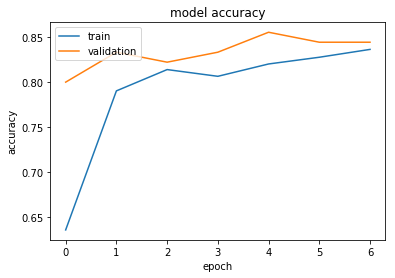

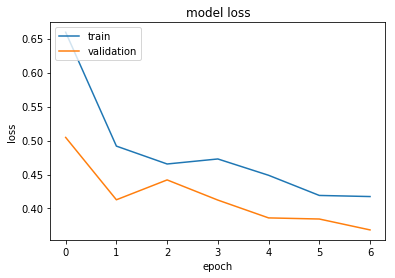

In [34]:
plt.plot(network.history.history['acc'])
plt.plot(network.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(network.history.history['loss'])
plt.plot(network.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## without early stopping:

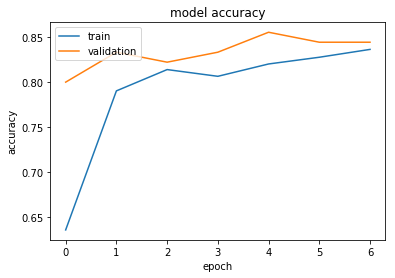

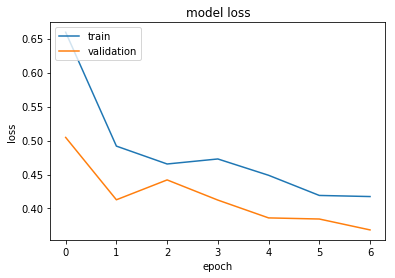

In [35]:
plt.plot(network.history.history['acc'])
plt.plot(network.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(network.history.history['loss'])
plt.plot(network.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [36]:
# looks like overfitting -- add more regularisation

## Save weights

In [37]:
# Save weights to a TensorFlow Checkpoint file
# By default, this saves the model's weights in the TensorFlow checkpoint file format.
network.save_weights(ds.output('weights'))


In [38]:
results = network.predict(test_passengers)

In [39]:
results.shape

(418, 2)

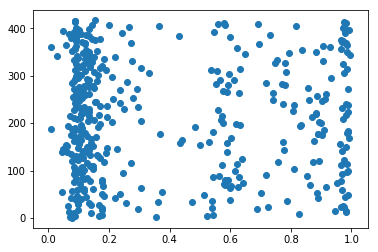

In [40]:
survived = []
for result in results:
    survived.append(result[1])


plt.scatter(survived, range(len(survived)))
plt.show()

In [41]:
# we need binary survival prediction, not a probability
binary_results = network.predict_classes(test_passengers)

In [42]:
binary_results

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [43]:
# get unwrangled version of test set with the passenger IDs
df_test = pd.read_csv("test.csv") 

In [44]:
# add column for binary survival status
df_test['Survived'] = binary_results


In [45]:
# write out results
df_test.drop(columns=['Pclass', 'Embarked', 'Name', 'Ticket', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Fare', 'Embarked'], inplace=True)
df_test.to_csv("predictions.csv", columns = ['PassengerId', 'Survived'], index=False) 
ds.output("predictions.csv")
df_test.reset_index(drop=True, inplace=True)


In [46]:
ds.publish("did it work?")

[[DOTSCIENCE-RUN:5ee74a44-4c2f-4ae1-9d7e-a6dd67869829]]{
    "description": "did it work?",
    "end": "20190204T165012.227836",
    "input": [
        "train.csv",
        "test.csv"
    ],
    "labels": {},
    "output": [
        "weights",
        "predictions.csv"
    ],
    "parameters": {
        "epochs": "700",
        "optimizer": "adam",
        "reg_lambda": "0.007"
    },
    "start": "20190204T165005.554414",
    "summary": {
        "acc%": "0.83645443196005"
    },
    "version": "1"
}[[/DOTSCIENCE-RUN:5ee74a44-4c2f-4ae1-9d7e-a6dd67869829]]
